# 基于CNN的物体识别

## 简介

使用`Keras`构建一个基础的CNN来对[CIFAR-10 图像库](https://www.cs.toronto.edu/~kriz/cifar.html)进行分类

## CNN

A [**neural network**](https://developers.google.cn/machine-learning/glossary/?hl=zh_cn#neural_network) in which at least one layer is a [**convolutional layer**](https://developers.google.cn/machine-learning/glossary/?hl=zh_cn#convolutional_layer).

>  A typical convolutional neural network consists of some combination of the following layers:
>
> - [**convolutional layers**](https://developers.google.cn/machine-learning/glossary/?hl=zh_cn#convolutional_layer)
> - [**pooling layers**](https://developers.google.cn/machine-learning/glossary/?hl=zh_cn#pooling)
> - [**dense layers**](https://developers.google.cn/machine-learning/glossary/?hl=zh_cn#dense_layer)
>
> Convolutional neural networks have had great success in certain kinds of problems, such as image recognition.
>
> [Machine Learning Glossary  | Google Developers](https://developers.google.cn/machine-learning/glossary/?hl=zh_cn#convolutional_neural_network)


## Keras

Keras 是一个用 Python 编写的高级神经网络 API，它能够以 [TensorFlow](https://github.com/tensorflow/tensorflow), [CNTK](https://github.com/Microsoft/cntk), 或者 [Theano](https://github.com/Theano/Theano) 作为后端运行。Keras 的开发重点是支持快速的实验。*能够以最小的时延把你的想法转换为实验结果，是做好研究的关键。*

如果你在以下情况下需要深度学习库，请使用 Keras：

- 允许简单而快速的原型设计（由于用户友好，高度模块化，可扩展性）。
- 同时支持卷积神经网络和循环神经网络，以及两者的组合。
- 在 CPU 和 GPU 上无缝运行。

## CIFAR-10

该数据集共有60000张彩色图像，这些图像是32*32，分为10个类，每类6000张图。这里面有50000张用于训练，构成了5个训练批，每一批10000张图；另外10000用于测试，单独构成一批。测试批的数据里，取自10类中的每一类，每一类随机取1000张。抽剩下的就随机排列组成了训练批。注意一个训练批中的各类图像并不一定数量相同，总的来看训练批，每一类都有5000张图。

# 导入依赖

顺便打印个版本号

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import platform
print("Python version: "+platform.python_version())
print("Tensorflow version: "+tf.__version__)
print("Available devices: "+ str(tf.config.experimental.list_physical_devices()))

Python version: 3.7.12
Tensorflow version: 2.8.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 导入数据集并归一化


[CIFAR10 小图像分类数据集- Keras 中文文档](https://keras.io/zh/datasets/#cifar10)

[标准化和归一化什么区别？ - 知乎 (zhihu.com)](https://www.zhihu.com/question/20467170)


首先参考`Keras`文档导入训练集和测试集数据(包含图片和标签)，然后将图片的像素信息从`[0，255]`缩放到`[0.1]`，加快计算，使模型更准确

根据数据集里附带的`batches.meta`文件，可以得到一个类别列表，其下表是其在数据集中定义的标签号


In [2]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
# In this way, the numbers will be small and the computation becomes easier and faster.
train_images, test_images = train_images / 255.0, test_images / 255.0

#  Classes in CIFAR-10 dataset, whose index is corresponding to its label number
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 11s 0us/step


# 数据集预览

取训练集中的第`[0,10,20,....,240]`共25个数据样本，使用Matplotlib绘制，确保数据集正确性

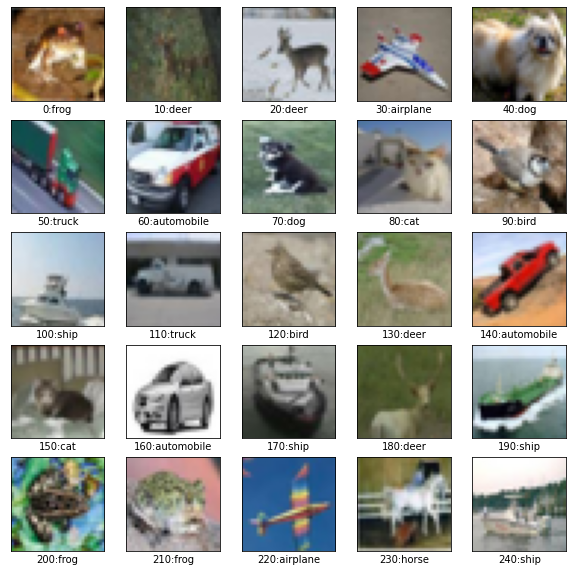

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    # (nrows, ncols, index), of which index starts at 1
    plt.subplot(5,5,i+1)
    # Hide axes and grids
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i*10])
    # The CIFAR labels happen to be arrays like [[1],[2],[3]], 
    # which is why you need the extra index
    plt.xlabel(str(i*10)+":"+class_names[train_labels[i*10][0]])
plt.show()

# 构建模型

使用Keras中最基本的Sequential模型

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

[Conv2D layer (keras.io)](https://keras.io/api/layers/convolution_layers/convolution2d/)

1. 对输入张量进行卷积运算
   - 输入张量大小为`(32,32,3)`，对应RGB三个通道上的图片
   - 卷积核大小为`3*3`
   - 激活函数选择`ReLU`
   - 输出通道数量为32（使用32个卷积核，产生32个特征图）

2. 对结果进行池化（降采样），采用`MaxPooling`，池大小为`2*2`

3. 对池化的样本进行第二次卷积运算，激活函数选择`ReLU`，输出通道数量为64

4. 再次进行池化，池化参数不变

5. 进行第三次卷积运算，激活函数选择`ReLU`，输出通道数量为64

6. 扁平化
   由于下一步的全连接层的输入为一维张量，当前输出为规格为(4,4,64)的三维张量，所以需要降维展开
7. 全连接
   将展开后大小为(1024)的张量顺序经过两个全连接层，最终输出10个分类的对应概率

In [4]:
from keras import models,layers

model = models.Sequential()
# Conv2D(filters,kernel_size,...)
# filters: Integer, the dimensionality of the output space 
# kernel_size:the height and width of the 2D convolution window.

# means that the input tensor is 32*32*3, where 3 is corresponding to (R,G,B),
# the kernel is 3*3 and the activation function is ReLU
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

# 网络信息

网络中每一层的类型，输出张量的形状，还有参数数量

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

# 训练并进行测试

- 优化器使用Adam(Adaptive Moment Estimation)，用于对参数的更新
- 使用稀疏分类交叉熵作为损失函数
- 评估项目为准确性

- 训练代数为10

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 22s 8ms/step - loss: 1.5522 - accuracy: 0.4321 - val_loss: 1.2635 - val_accuracy: 0.5397
Epoch 2/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.1893 - accuracy: 0.5762 - val_loss: 1.0846 - val_accuracy: 0.6156
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0428 - accuracy: 0.6340 - val_loss: 1.0276 - val_accuracy: 0.6358
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9490 - accuracy: 0.6672 - val_loss: 0.9466 - val_accuracy: 0.6666
Epoch 5/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8741 - accuracy: 0.6947 - val_loss: 0.8981 - val_accuracy: 0.6917
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8192 - accuracy: 0.7144 - val_loss: 0.8715 - val_accuracy: 0.6973
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7744 - accuracy: 0.7278 - val_loss: 0.9180 - val_ac

# 模型评估可视化

随着训练代数的增多，模型在训练集和测试集的表现总体上升，最终的预测准确率保持在70%左右

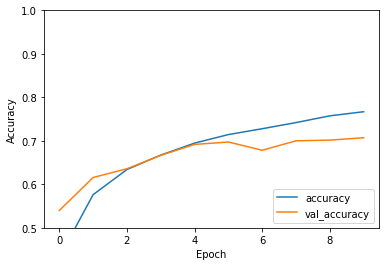

313/313 - 1s - loss: 0.8707 - accuracy: 0.7071 - 1s/epoch - 3ms/step


In [7]:
# Train set
plt.plot(history.history['accuracy'], label='accuracy')
# Test set
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [9]:
print("Prediction accuracy: "+str(test_acc))

Prediction accuracy: 0.707099974155426
